In [2]:
# 데이터분석
import pandas as pd
import numpy as np 

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc 

import os
import warnings
import random

# ML/DL 모델 및 sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 경고 끄기
warnings.filterwarnings(action='ignore')

# 데이터프레임 제한 풀기
pd.set_option('display.max_row', 100)
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_seq_items', None)

### 전처리

In [3]:
# 월 평균값 있을때
df = pd.read_csv('./우양 - 주가,코스피원본.csv')
df.date = pd.to_datetime(df.date)
df['date'] = df['date'].dt.strftime('%Y-%m')
df = df.set_index('date')

# MinMaxScaler로 price, kospi 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df)
scaled = scaler.transform(df)
df_scaled = pd.DataFrame(scaled, columns=['pricemm','kospimm'])
df = df.reset_index('date')
df_scaled.insert(0,'date', df['date'] )

df = df.merge(df_scaled,how='left')
df.head()

,date,price_month,kospi_month,pricemm,kospimm
0,2019-11,4888.750000,2128.794762,0.501737,0.232308
1,2019-12,4082.000000,2147.013500,0.221417,0.244681
2,2020-01,3942.000000,2203.442500,0.172771,0.283006
3,2020-02,4240.500000,2167.123500,0.276491,0.258339
4,2020-03,3444.772727,1786.746364,0.000000,0.000000


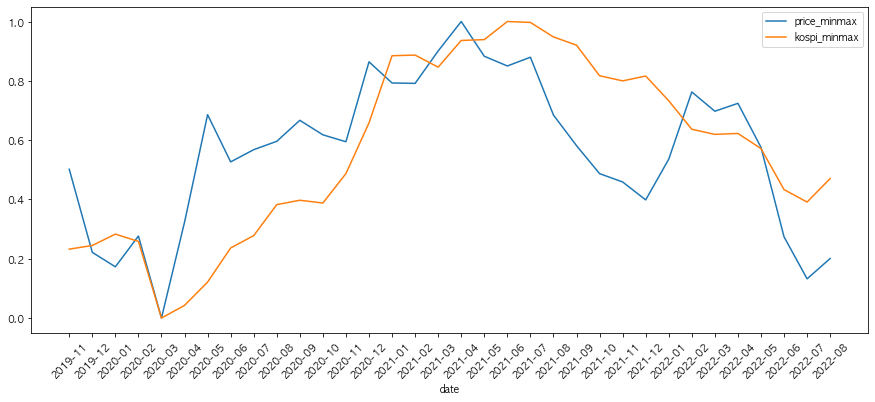

In [4]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'
# plt.rcParams['font.size'] = 23
# plt.rcParams['figure.figsize'] = (13, 8) # figsize 고정
sns.lineplot(data=df, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df, x="date", y="kospimm", label='kospi_minmax')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

In [5]:
# 스케일링한 주가와 코스피 지수의 기울기(가격 변화량/시간 변화량) 도출
for i in range(len(df)-1): 
    df.loc[i+1,'price_slope'] = df.loc[i+1,'pricemm']-df.loc[i,'pricemm']
    df.loc[i+1,'kospi_slope'] = df.loc[i+1,'kospimm']-df.loc[i,'kospimm']

df = df.bfill()

for i in range(len(df)):
    df.loc[i,'k_s - p_s'] = df.loc[i,'kospi_slope'] - df.loc[i,'price_slope']

    if df.loc[i,'price_slope'] < df.loc[i,'kospi_slope']:
        df.loc[i, 'downturn'] = 1
    else:
        df.loc[i, 'downturn'] = 0

df.head()

,date,price_month,kospi_month,pricemm,kospimm,price_slope,kospi_slope,k_s - p_s,downturn
0,2019-11,4888.750000,2128.794762,0.501737,0.232308,-0.280321,0.012374,0.292694,1.0
1,2019-12,4082.000000,2147.013500,0.221417,0.244681,-0.280321,0.012374,0.292694,1.0
2,2020-01,3942.000000,2203.442500,0.172771,0.283006,-0.048646,0.038325,0.086970,1.0
3,2020-02,4240.500000,2167.123500,0.276491,0.258339,0.103719,-0.024667,-0.128386,0.0
4,2020-03,3444.772727,1786.746364,0.000000,0.000000,-0.276491,-0.258339,0.018151,1.0


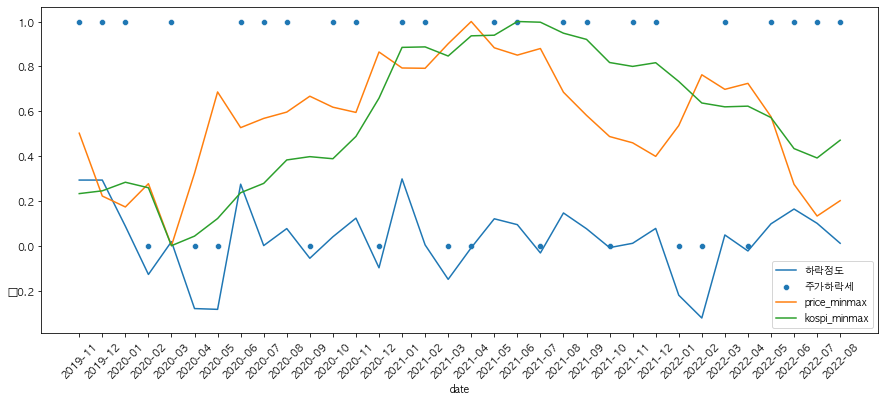

In [6]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.lineplot(data=df, x="date", y="k_s - p_s", label='하락정도')
sns.scatterplot(data=df, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df, x="date", y="kospimm", label='kospi_minmax')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

In [7]:
df.to_csv('yvalue.csv',index=False)

- downturn이 target(y값) feature입니다.

#### feature importance로 feature selection

(27, 4)
(7, 4)
1    0.666667
0    0.333333
Name: downturn, dtype: float64
1    0.571429
0    0.428571
Name: downturn, dtype: float64
정확도 :  0.5714285714285714


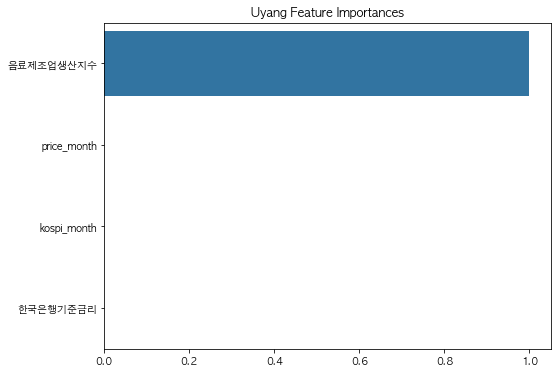

,downturn,price_month,kospi_month,음료제조업생산지수,한국은행기준금리
date,,,,,
2019-11-01,1,4888.750000,2128.794762,93.2,1.25
2019-12-01,1,4082.000000,2147.013500,90.2,1.25
2020-01-01,1,3942.000000,2203.442500,97.1,1.25
2020-02-01,0,4240.500000,2167.123500,90.0,1.25
2020-03-01,1,3444.772727,1786.746364,92.7,0.75


In [8]:
# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_csv('./Uyang_feature_importance.csv')
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['k_s - p_s'], axis=1)

from xgboost import XGBClassifier
import xgboost

# train, test split (8:2)
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['downturn'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

# 0,1이 고르게 나누어졌을까?
print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# CART 모델 학습
model = XGBClassifier(gamma=3, learning_rate=0.3)
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)
print('정확도 : ', accuracy_score(y_pred, y_test))

# feature importance 확인
# fig, ax = plt.subplots(1,1,figsize=(10,8))
# plt.rcParams['font.family'] = 'AppleGothic'
# xgboost.plot_importance(model, title='feature_importances', xlabel='', ax=ax, max_num_features=20, height=0.4)
# plt.show()
ftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)

ftr_top5 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'AppleGothic'
plt.title('Uyang Feature Importances') # 그래프 제목을 변경해주세요
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()
df_f.head()

- accuracy가 0.7 이 넘는 데이터에서 나온 feature만 확인
- 음료제조업생산지수 하나 밖에 없습니다.

(27, 22)
(7, 22)
1    0.666667
0    0.333333
Name: downturn, dtype: float64
1    0.571429
0    0.428571
Name: downturn, dtype: float64
정확도 :  0.5714285714285714


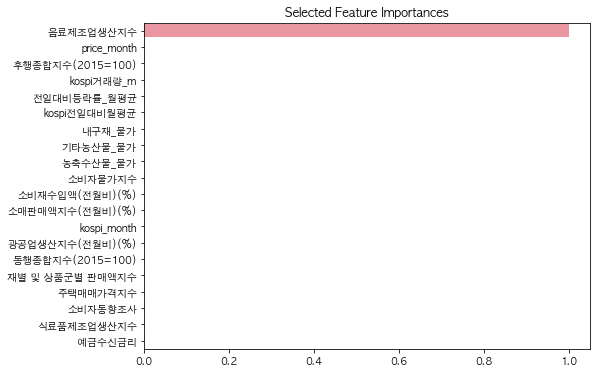

,downturn,price_month,kospi_month,경제활동인구,예금수신금리,식료품제조업생산지수,음료제조업생산지수,소비자동향조사,주택매매가격지수,재별 및 상품군별 판매액지수,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,전일대비등락률_월평균,kospi거래량_m,한국은행기준금리
date,,,,,,,,,,,,,,,,,,,,,,,
2019-11-01,1,4888.750000,2128.794762,3.7,1.62,110.2,93.2,101.5,90.0,116.0,113.0,0.3,0.3,115.1,-3.3,99.481,92.064,95.365,98.976,0.213333,0.013810,511316.6190,1.25
2019-12-01,1,4082.000000,2147.013500,3.7,1.60,111.0,90.2,101.1,90.3,117.1,113.5,0.7,1.4,115.4,0.9,99.719,93.953,96.100,99.085,5.485500,0.258500,509437.6000,1.25
2020-01-01,1,3942.000000,2203.442500,3.8,1.54,108.9,97.1,104.7,90.6,113.5,114.0,0.5,0.3,115.6,-0.8,100.090,95.630,97.590,99.680,-3.933000,-0.174500,654803.4000,1.25
2020-02-01,0,4240.500000,2167.123500,3.3,1.43,102.1,90.0,97.6,90.9,106.2,113.3,-0.6,-2.8,115.9,-0.6,100.160,94.730,95.820,100.210,-6.600000,-0.308000,697988.3000,1.25
2020-03-01,1,3444.772727,1786.746364,3.7,1.27,112.6,92.7,79.9,91.4,105.4,112.3,-0.3,-3.5,116.0,-2.9,99.940,96.570,93.740,98.770,-10.562273,-0.479091,776864.7727,0.75


In [9]:
# 데이터 불러오기 및 날짜 인덱스 지정
df_f = pd.read_csv('./Uyang_features.csv')
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['k_s - p_s'], axis=1)

from xgboost import XGBClassifier
import xgboost

# train, test split
X_train, X_test, y_train, y_test = train_test_split(df_f.iloc[:,1:], df_f['downturn'], test_size=0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print(X_train.shape)
print(X_test.shape)

print(y_train.value_counts()/train_cnt)
print(y_test.value_counts()/test_cnt)

# CART 모델
model = XGBClassifier(gamma=3, learning_rate=0.3)
model.fit(X_train, y_train)
# model.fit(X_train_resampled, y_train_resampled)

y_pred = model.predict(X_test)
print('정확도 : ',accuracy_score(y_pred, y_test))

ftr_importances = pd.Series(model.feature_importances_, index = X_train.columns)

ftr_top5 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.rcParams['font.family'] = 'AppleGothic'
plt.title('Selected Feature Importances')
sns.barplot(x=ftr_top5, y=ftr_top5.index)
plt.show()
df_f.head()

- 식료품 마켓컬리 테마주라고 해석됩니다. 거시적인 경제 지표의 영향을 상대적으로 덜 받는다고 해석합니다.
### 하락 팩터 찾기

In [10]:
## feature selection된 데이터 MinMaxScaling
df_f = pd.read_csv('./Uyang_features_plus.csv')  ## 국제 데이터 추가
df_f.date = pd.to_datetime(df_f.date)
df_f = df_f.set_index('date')
df_f = df_f.drop(['k_s - p_s'], axis=1)


df_f = df_f.drop(['price_month', 'downturn', 'kospi_month'], axis=1)

# MinMaxScaler로 price, kospi 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df_f)
scaled = scaler.transform(df_f)
df_scaled = pd.DataFrame(scaled, columns=list(df_f.columns))

# 정규화한 데이터에 날짜 열 추가
df_scaled.insert(0,'date', df['date'] )

In [11]:
 df_scaled.head()

,date,경제활동인구,예금수신금리,식료품제조업생산지수,음료제조업생산지수,소비자동향조사,주택매매가격지수,재별 및 상품군별 판매액지수,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,전일대비등락률_월평균,kospi거래량_m,한국은행기준금리,휘발유(95RON),휘발유(92RON),등유,경유(0.001%),경유(0.05%),고유황중유(180cst/3.5%),나프타,미국금리,연준금리,gv_3y,gv_5y,gv_10y,cb_3y,CD 91물(평균),callint,기준금리,DJ,Nasdaq,S&P
0,2019-11,0.444444,0.373272,0.553719,0.235119,0.767196,0.000000,0.595506,0.204724,0.524590,0.535211,0.000000,0.000000,0.004409,0.000000,0.115836,0.050000,0.511308,0.470982,0.102737,0.375,0.413870,0.401005,0.455749,0.429154,0.332928,0.182574,0.452128,0.666667,0.666667,0.249057,0.195312,0.171053,0.066946,0.412037,0.449438,0.375,0.390551,0.092676,0.223752
1,2019-12,0.444444,0.364055,0.586777,0.145833,0.756614,0.020270,0.657303,0.244094,0.590164,0.690141,0.022556,0.545455,0.030000,0.076552,0.146628,0.076456,0.680542,0.676296,0.101280,0.375,0.403178,0.400773,0.473154,0.447276,0.353960,0.227221,0.495014,0.666667,0.666667,0.211321,0.152344,0.127193,0.046025,0.416667,0.449438,0.375,0.418554,0.125130,0.259277
2,2020-01,0.481481,0.336406,0.500000,0.351190,0.851852,0.040541,0.455056,0.283465,0.557377,0.535211,0.037594,0.324675,0.069892,0.144513,0.209049,0.220874,0.378213,0.312976,0.214012,0.375,0.376893,0.383849,0.458853,0.431872,0.338436,0.325854,0.467138,0.666667,0.666667,0.203774,0.152344,0.131579,0.050209,0.388889,0.443820,0.375,0.472523,0.181674,0.309442
3,2020-02,0.296296,0.285714,0.219008,0.139881,0.664021,0.060811,0.044944,0.228346,0.377049,0.098592,0.060150,0.350649,0.077419,0.108040,0.134897,0.349515,0.292603,0.200959,0.247503,0.375,0.326255,0.333230,0.383693,0.372183,0.256957,0.265831,0.375469,0.666667,0.666667,0.158491,0.105469,0.078947,0.004184,0.365741,0.426966,0.375,0.445254,0.204737,0.309003
4,2020-03,0.444444,0.211982,0.652893,0.220238,0.195767,0.094595,0.000000,0.149606,0.426230,0.000000,0.067669,0.051948,0.053763,0.182607,0.047759,0.000000,0.165416,0.057400,0.308673,0.125,0.118280,0.121638,0.239278,0.256145,0.112383,0.092711,0.139059,0.444444,0.444444,0.098113,0.070312,0.057018,0.000000,0.277778,0.280899,0.125,0.000000,0.000000,0.000000


In [12]:
df.head()

,date,price_month,kospi_month,pricemm,kospimm,price_slope,kospi_slope,k_s - p_s,downturn
0,2019-11,4888.750000,2128.794762,0.501737,0.232308,-0.280321,0.012374,0.292694,1.0
1,2019-12,4082.000000,2147.013500,0.221417,0.244681,-0.280321,0.012374,0.292694,1.0
2,2020-01,3942.000000,2203.442500,0.172771,0.283006,-0.048646,0.038325,0.086970,1.0
3,2020-02,4240.500000,2167.123500,0.276491,0.258339,0.103719,-0.024667,-0.128386,0.0
4,2020-03,3444.772727,1786.746364,0.000000,0.000000,-0.276491,-0.258339,0.018151,1.0


In [13]:
df_result = df.merge(df_scaled, how='left')
df_result.head()

,date,price_month,kospi_month,pricemm,kospimm,price_slope,kospi_slope,k_s - p_s,downturn,경제활동인구,예금수신금리,식료품제조업생산지수,음료제조업생산지수,소비자동향조사,주택매매가격지수,재별 및 상품군별 판매액지수,동행종합지수(2015=100),광공업생산지수(전월비)(%),소매판매액지수(전월비)(%),후행종합지수(2015=100),소비재수입액(전월비)(%),소비자물가지수,농축수산물_물가,기타농산물_물가,내구재_물가,kospi전일대비월평균,전일대비등락률_월평균,kospi거래량_m,한국은행기준금리,휘발유(95RON),휘발유(92RON),등유,경유(0.001%),경유(0.05%),고유황중유(180cst/3.5%),나프타,미국금리,연준금리,gv_3y,gv_5y,gv_10y,cb_3y,CD 91물(평균),callint,기준금리,DJ,Nasdaq,S&P
0,2019-11,4888.750000,2128.794762,0.501737,0.232308,-0.280321,0.012374,0.292694,1.0,0.444444,0.373272,0.553719,0.235119,0.767196,0.000000,0.595506,0.204724,0.524590,0.535211,0.000000,0.000000,0.004409,0.000000,0.115836,0.050000,0.511308,0.470982,0.102737,0.375,0.413870,0.401005,0.455749,0.429154,0.332928,0.182574,0.452128,0.666667,0.666667,0.249057,0.195312,0.171053,0.066946,0.412037,0.449438,0.375,0.390551,0.092676,0.223752
1,2019-12,4082.000000,2147.013500,0.221417,0.244681,-0.280321,0.012374,0.292694,1.0,0.444444,0.364055,0.586777,0.145833,0.756614,0.020270,0.657303,0.244094,0.590164,0.690141,0.022556,0.545455,0.030000,0.076552,0.146628,0.076456,0.680542,0.676296,0.101280,0.375,0.403178,0.400773,0.473154,0.447276,0.353960,0.227221,0.495014,0.666667,0.666667,0.211321,0.152344,0.127193,0.046025,0.416667,0.449438,0.375,0.418554,0.125130,0.259277
2,2020-01,3942.000000,2203.442500,0.172771,0.283006,-0.048646,0.038325,0.086970,1.0,0.481481,0.336406,0.500000,0.351190,0.851852,0.040541,0.455056,0.283465,0.557377,0.535211,0.037594,0.324675,0.069892,0.144513,0.209049,0.220874,0.378213,0.312976,0.214012,0.375,0.376893,0.383849,0.458853,0.431872,0.338436,0.325854,0.467138,0.666667,0.666667,0.203774,0.152344,0.131579,0.050209,0.388889,0.443820,0.375,0.472523,0.181674,0.309442
3,2020-02,4240.500000,2167.123500,0.276491,0.258339,0.103719,-0.024667,-0.128386,0.0,0.296296,0.285714,0.219008,0.139881,0.664021,0.060811,0.044944,0.228346,0.377049,0.098592,0.060150,0.350649,0.077419,0.108040,0.134897,0.349515,0.292603,0.200959,0.247503,0.375,0.326255,0.333230,0.383693,0.372183,0.256957,0.265831,0.375469,0.666667,0.666667,0.158491,0.105469,0.078947,0.004184,0.365741,0.426966,0.375,0.445254,0.204737,0.309003
4,2020-03,3444.772727,1786.746364,0.000000,0.000000,-0.276491,-0.258339,0.018151,1.0,0.444444,0.211982,0.652893,0.220238,0.195767,0.094595,0.000000,0.149606,0.426230,0.000000,0.067669,0.051948,0.053763,0.182607,0.047759,0.000000,0.165416,0.057400,0.308673,0.125,0.118280,0.121638,0.239278,0.256145,0.112383,0.092711,0.139059,0.444444,0.444444,0.098113,0.070312,0.057018,0.000000,0.277778,0.280899,0.125,0.000000,0.000000,0.000000


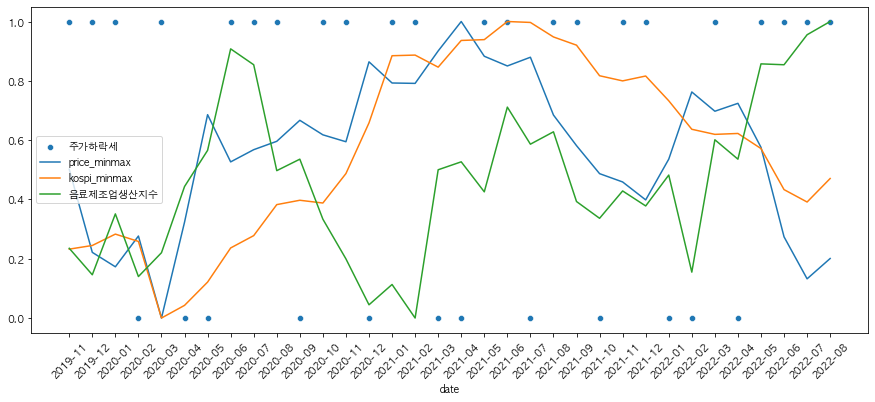

In [14]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="음료제조업생산지수", label='음료제조업생산지수')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

생산지수는 기준시점에 대한 품목별 생산수량의 신장을, 기준시점에 있어서의 부가가치(생산금액의 원재료비 등을 차감한 것)를 웨이트로 하여 가중 평균한 것이며, 생산의 수량적 확대의 정도를 나타냅니다.

우양은 음료, 농축액, 스무디 총 32개의 제품이 있습니다.

음료제조업생산지수가 하락할 때 같이 하락하는 시점 (21년 6월)이 존재하긴 하지만, 같은 경향이 아닌 부분이 더 많습니다. 

종합적인 지수라서 소기업인 우양을 잘 반영하지 못한다고 생각할 수 있습니다.

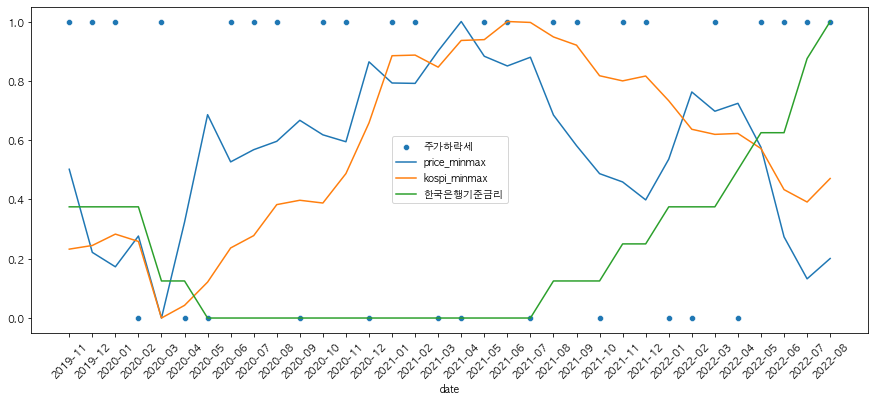

In [15]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="한국은행기준금리", label='한국은행기준금리')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

기준 금리가 하락할 때 (20년 2월)에 주가가 상승하였고, 기준 금리 상승 시그널이 있을 때(21년 5월) 그리고 실제로 기준 금리가 상승하자(21년 7월) 주가가 하락합니다.

올해 본격적으로 한은 총재 교체 이후 미국의 빅스텝과 더불어 금리가 상승하자 주가가 하락합니다. (22년 4월)

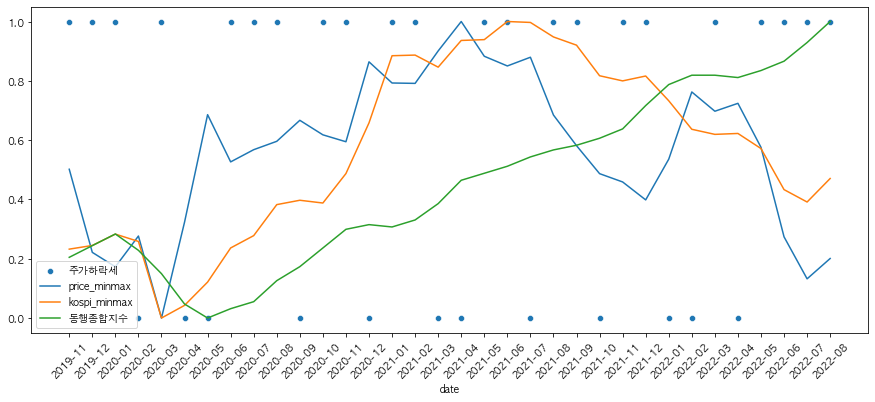

In [16]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="동행종합지수(2015=100)", label='동행종합지수')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

삭제하죠

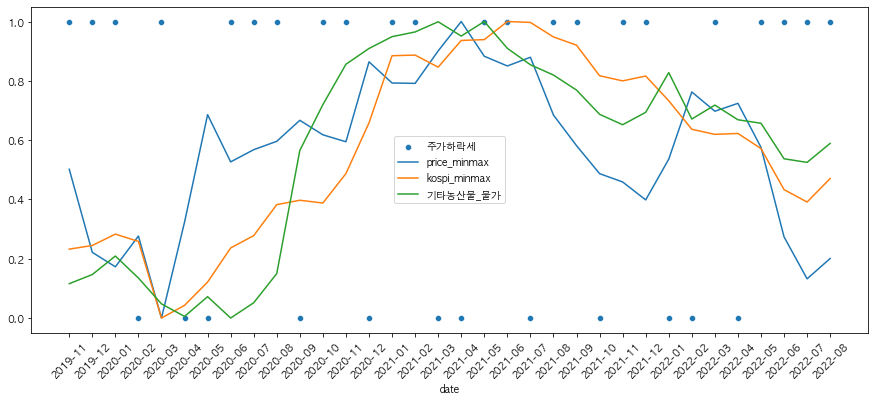

In [17]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="기타농산물_물가", label='기타농산물_물가')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

기타농산물 물가지수가 하락할 때 주가도 하락세를 탄다. (검증)

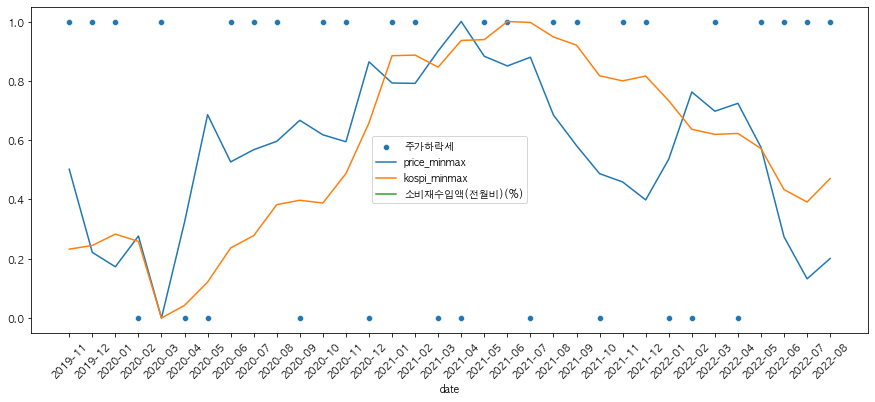

In [18]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, y="소비재수입액(전월비)(%)", label='소비재수입액(전월비)(%)')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

버리죠

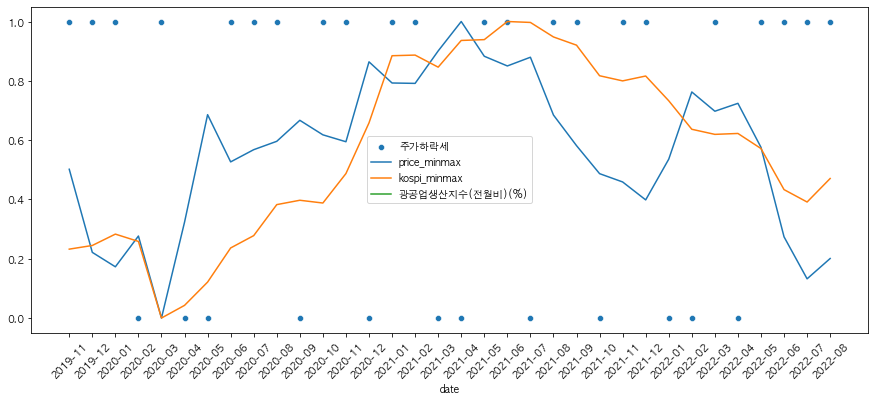

In [19]:
# 주가 데이터 그래프
plt.figure(figsize=(15, 6))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, y="광공업생산지수(전월비)(%)", label='광공업생산지수(전월비)(%)')

plt.ylabel('')
plt.xticks(rotation=45)

plt.show()

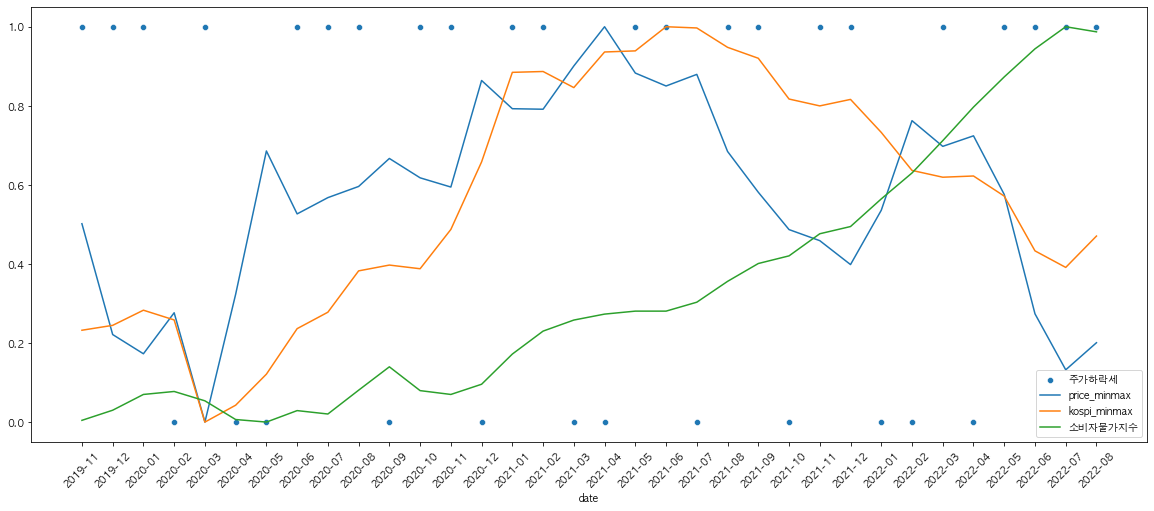

In [20]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="소비자물가지수", label='소비자물가지수')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

소비자 물가지수가 일정 지수(약 102) 이하 이면 하락세인 경향을 보인다. (검증 x, 버리죠)

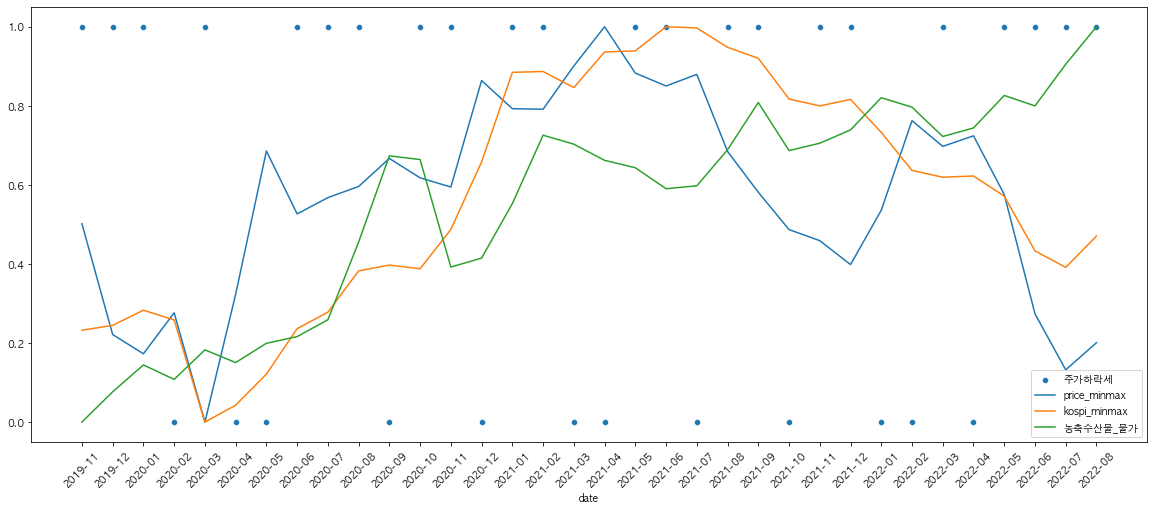

In [21]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="농축수산물_물가", label='농축수산물_물가')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

농축수산물 물가 상승시에 하락세인 경향을 보인다. (20년 2월, 21년 7월, 22년 4월) (검증)

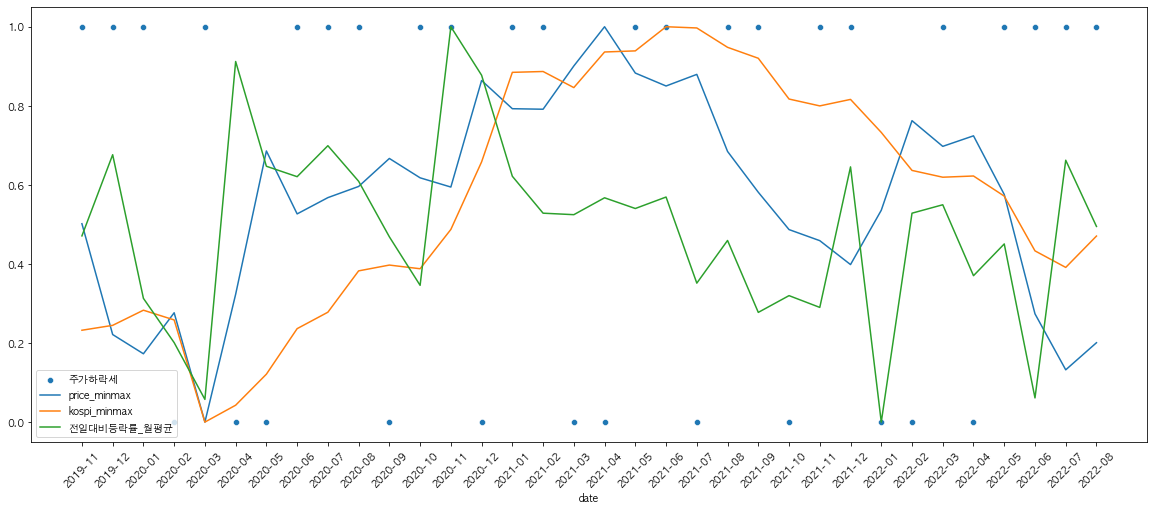

In [22]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="전일대비등락률_월평균", label='전일대비등락률_월평균')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

- kospi의 전일대비등락률의 월평균 값이 월간 0.45이상 차이 난다면 상승세와 하락세의 전환이 일어날 가능성이 높다. (여긴 버리죠)

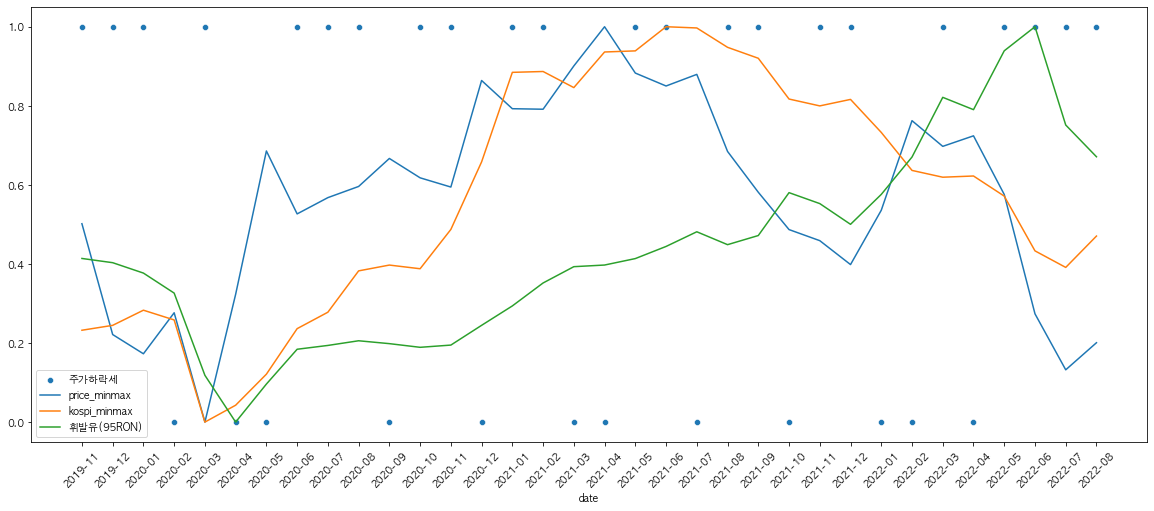

In [23]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="휘발유(95RON)", label='휘발유(95RON)')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

20년 5월에 휘발유 가격이 상승할 때 주가가 하락하는 부분이 있고 22년 4월 휘발유 가격이 폭등할 때 주가가 하락하는 부분도 찾을 수 있습니다.

하지만 20년부터 21년까지 지속적으로 휘발유 가격은 올랐으나 주식 가격은 변동이 많기 때문에 설명력이 떨어집니다.

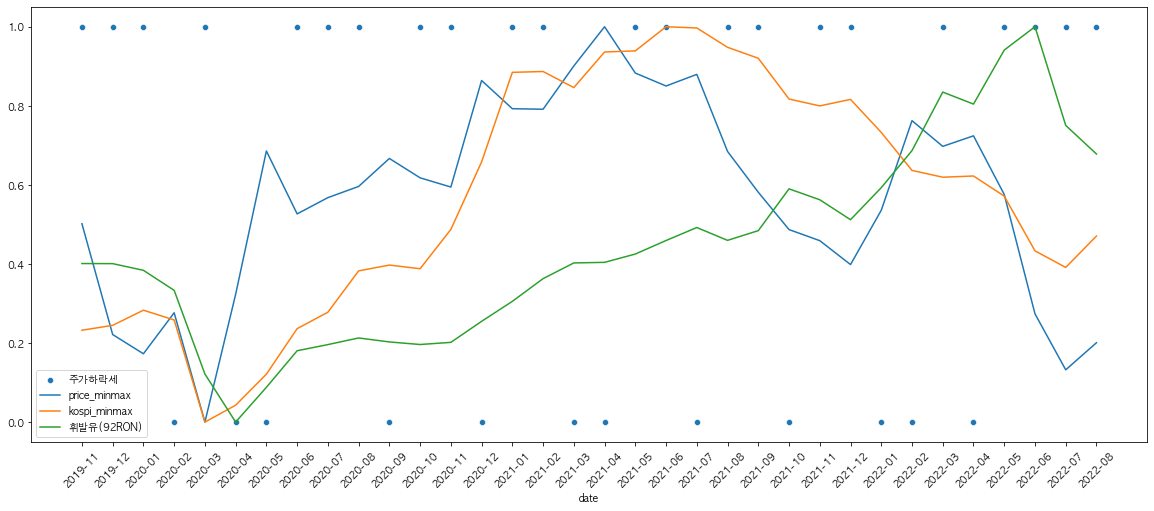

In [24]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="휘발유(92RON)", label='휘발유(92RON)')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

95 휘발유랑 동일하게 설명할 수 있습니다.

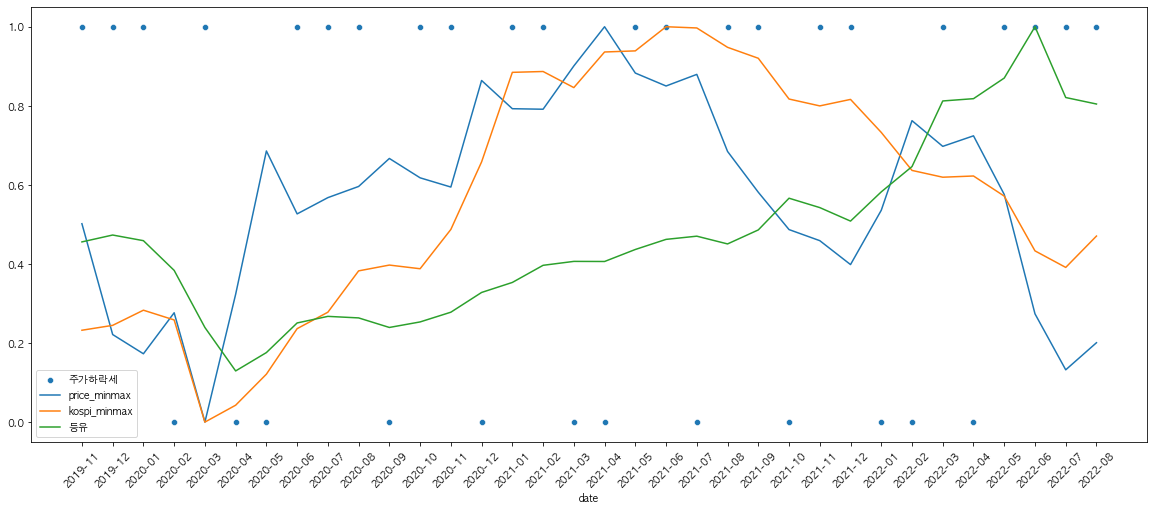

In [25]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="등유", label='등유')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

유가는 세분화 해서 분석하는 것이 크게 의미가 없는듯 합니다. 모두 비슷한 경향입니다.

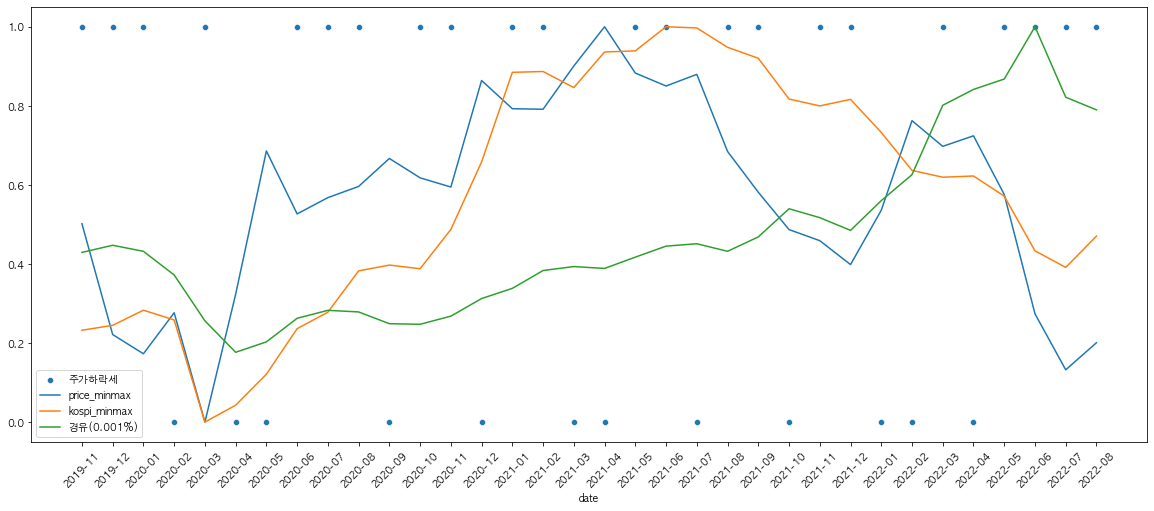

In [26]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="경유(0.001%)", label='경유(0.001%)')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

이하 동문

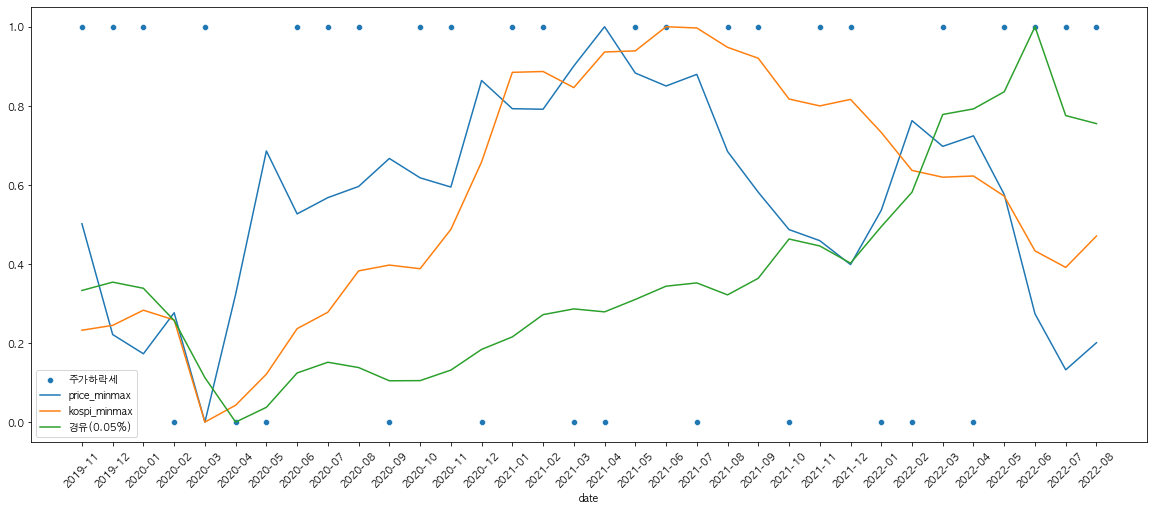

In [27]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="경유(0.05%)", label='경유(0.05%)')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

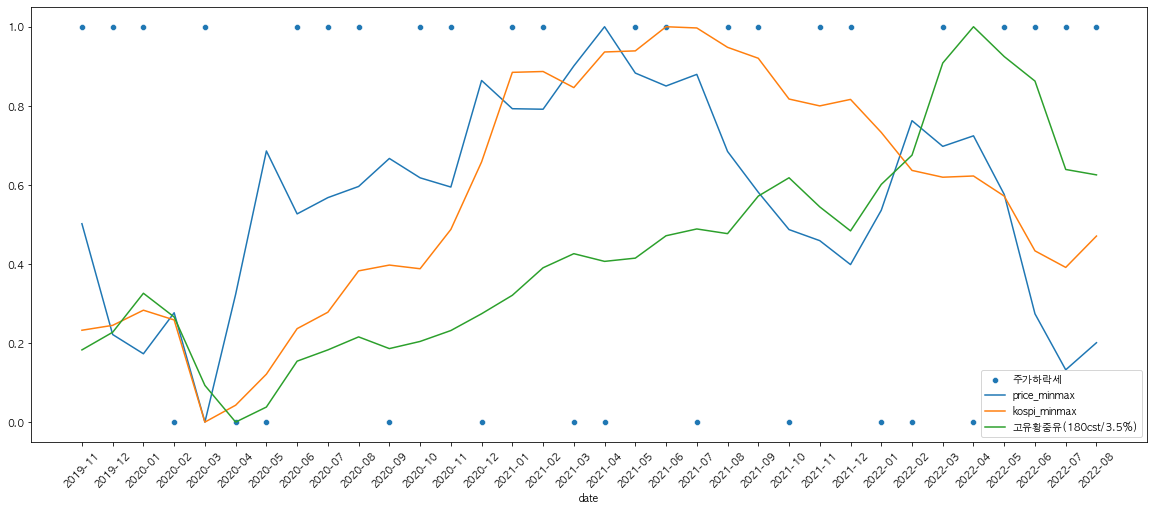

In [28]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="고유황중유(180cst/3.5%)", label='고유황중유(180cst/3.5%)')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

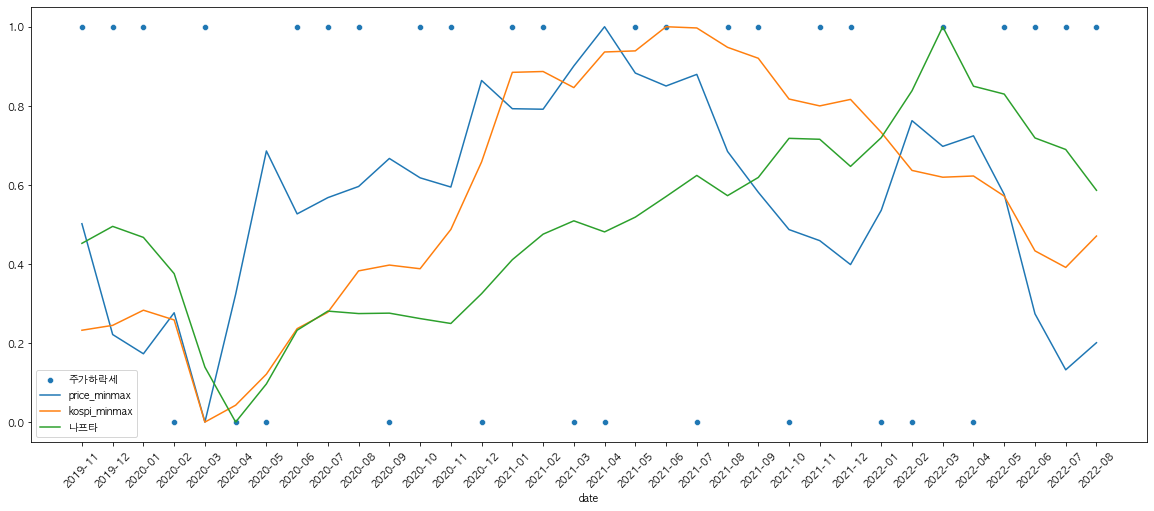

In [29]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="나프타", label='나프타')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

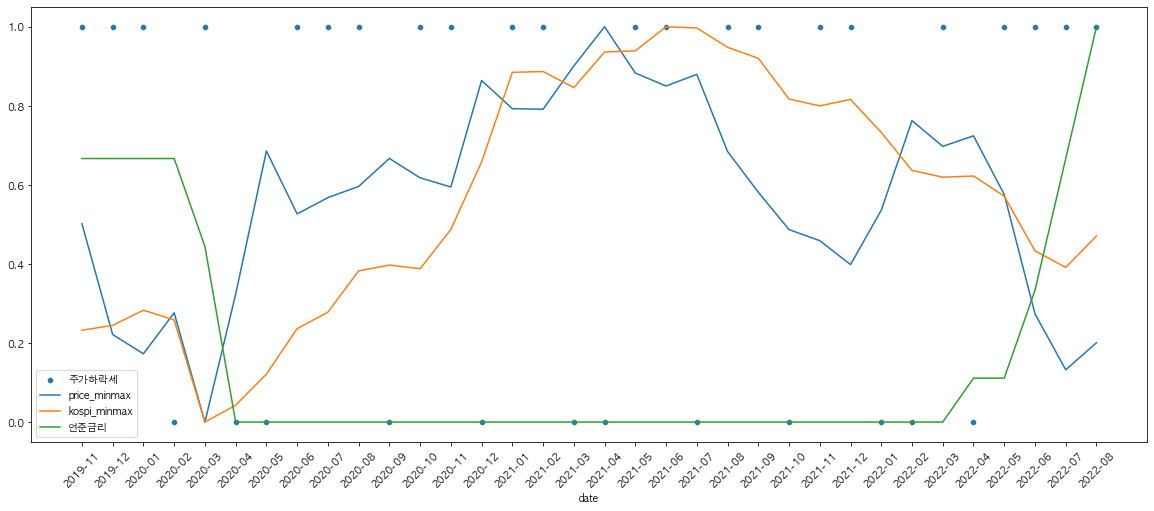

In [30]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="연준금리", label='연준금리')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

확실하게 연준금리가 22년 5월에 빅스탭을 밟으면서 한국 주식이 전부 떨어졌음을 확인할 수 있습니다.

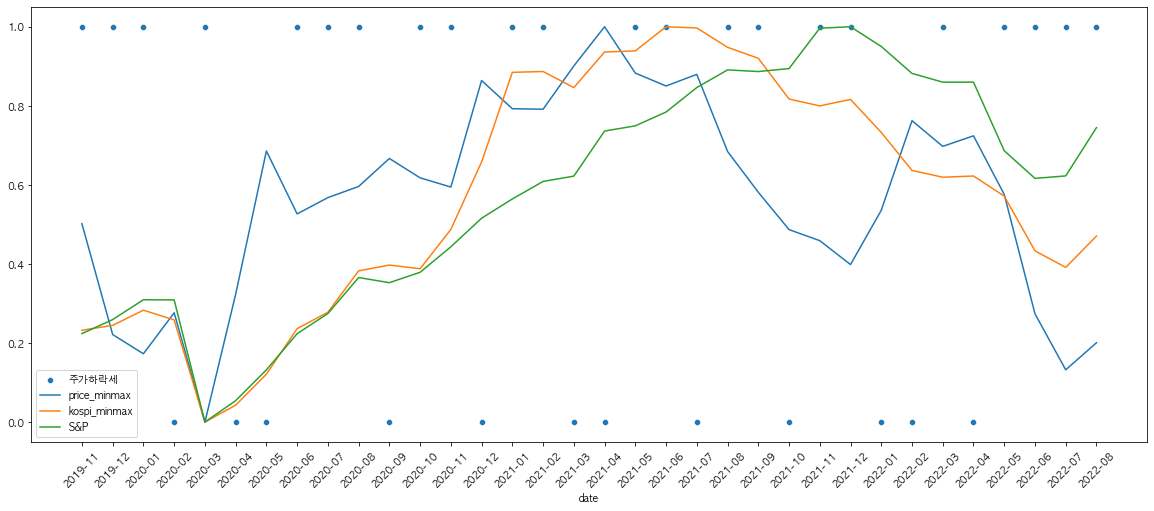

In [31]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="S&P", label='S&P')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

splt.show()

  코로나 때 S&P가 저점을 찍고 꾸준히 상승하였습니다. 우양 주식은 그에 비해 변동이 큽니다.
  
  설명력이 부족합니다.

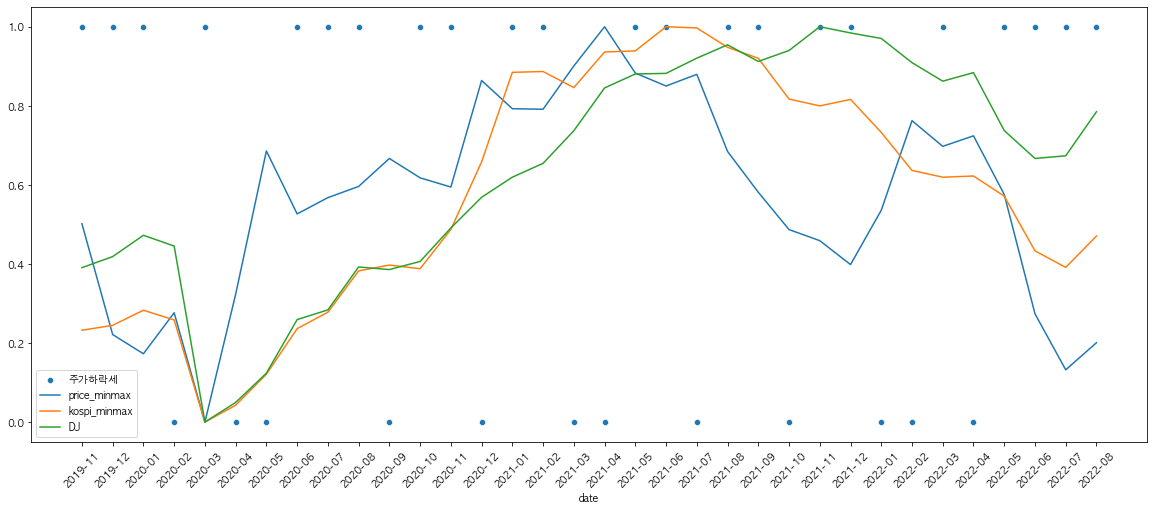

In [37]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="DJ", label='DJ')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

S & P와 이하동문

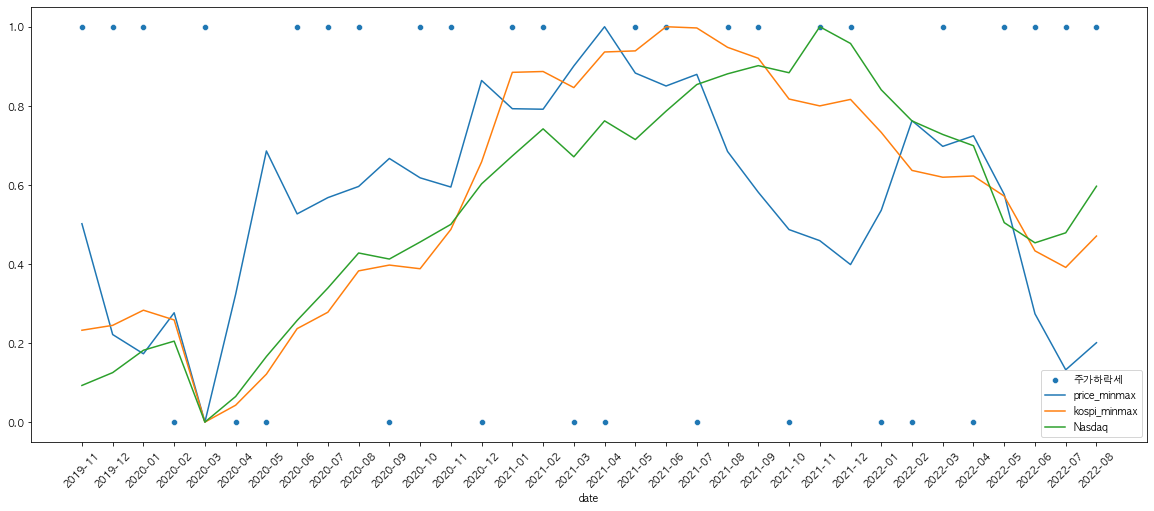

In [38]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="Nasdaq", label='Nasdaq')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

S & P, DJ와 이하동문

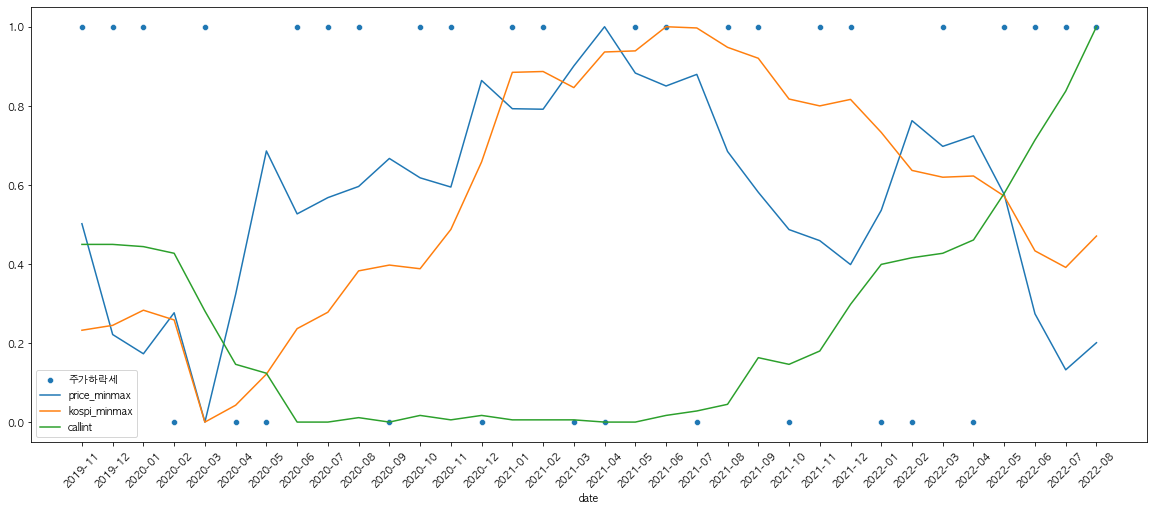

In [39]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="callint", label='callint')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

콜 금리의 경우 그냥 한국 기준금리랑 사실상 같은 지표라고 보면 됩니다. 

콜 금리와 주가는 음의 상관관계임을 확인할 수 있습니다.

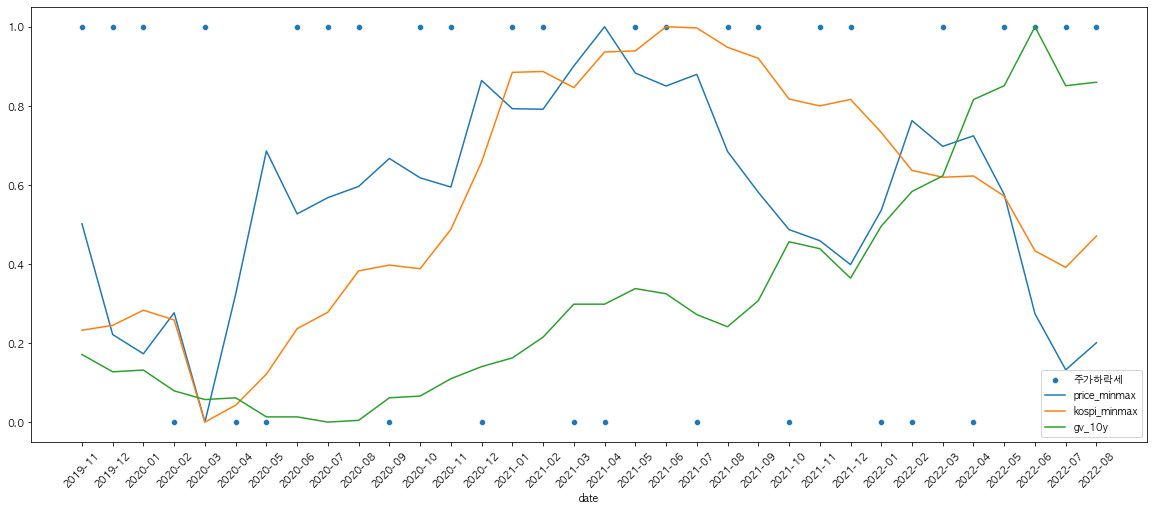

In [41]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="gv_10y", label='gv_10y')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

국채금리(장기) 설명 불가.. 너무 잡주라서 장기 지표랑 큰 연관이..?

물론 올해 22년 4월 부터 한은도 빅스탭을 밟으면서 국채금리도 오르고, 주가도 떨어지고 이런 현상을 관찰할 수 있습니다.

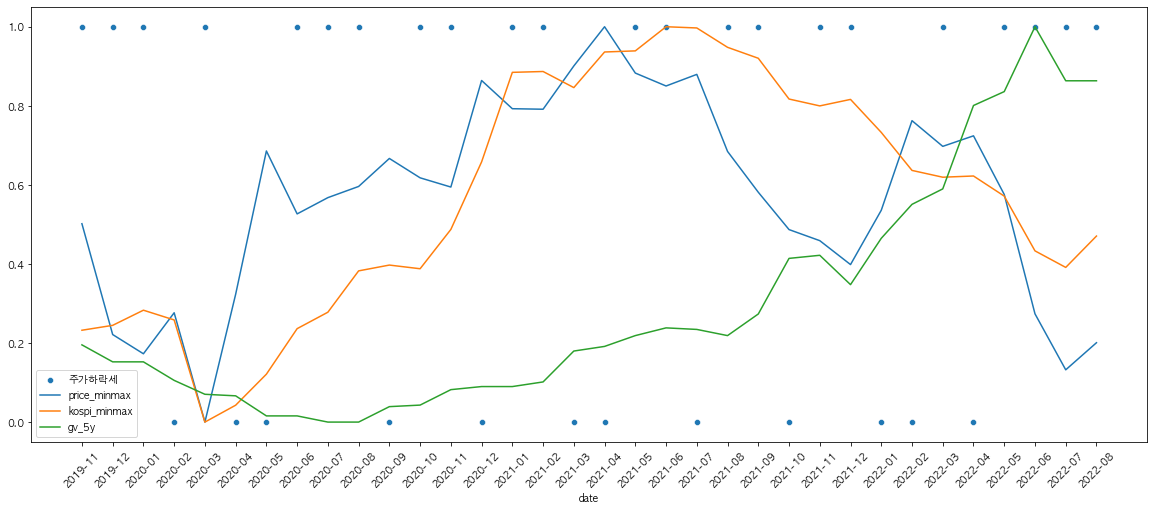

In [42]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="gv_5y", label='gv_5y')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

5년물도 마찬가지

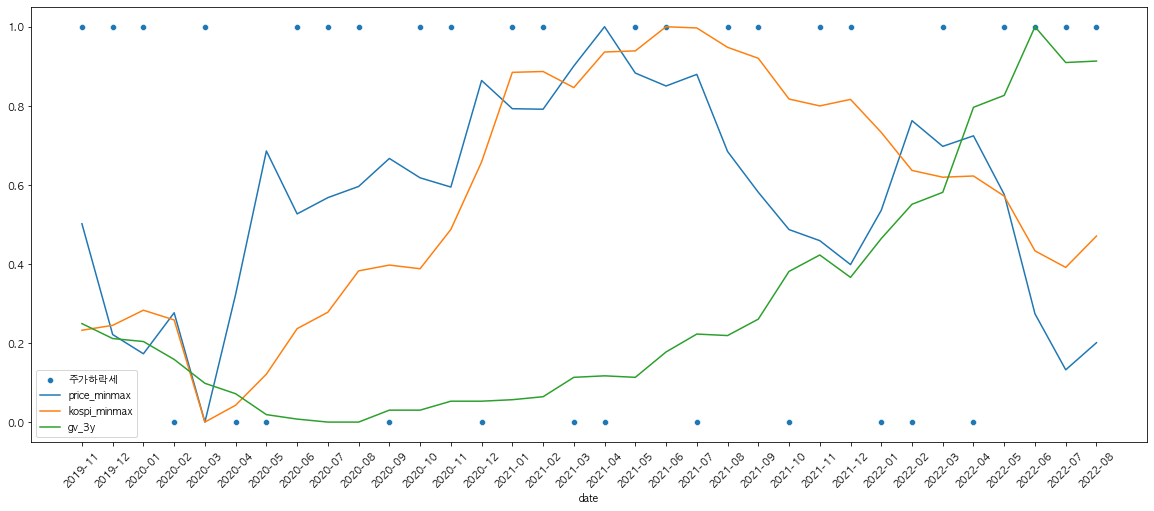

In [43]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="gv_3y", label='gv_3y')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

3년물도 별 차이 없구요

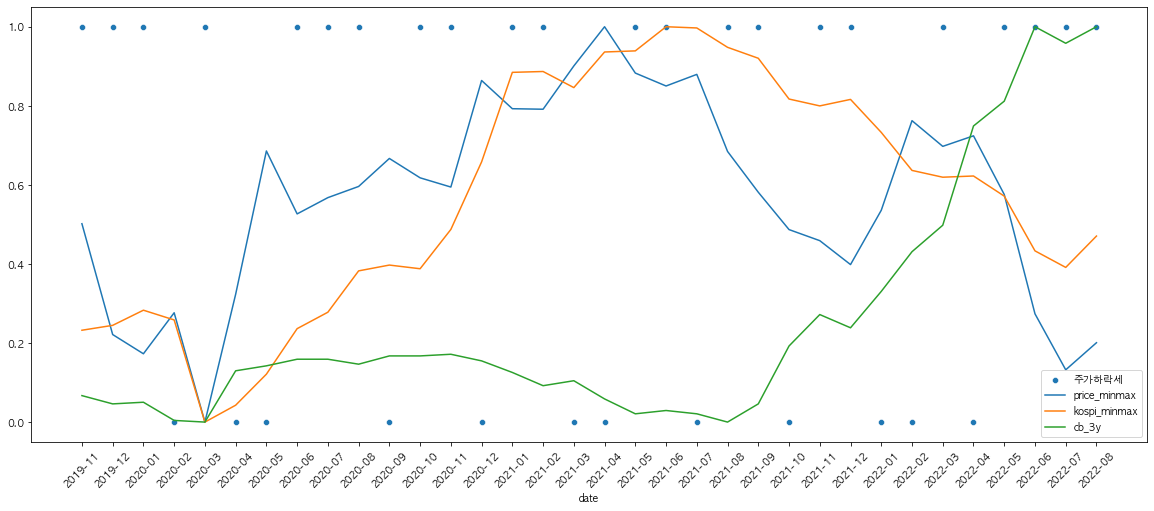

In [44]:
# 주가 데이터 그래프
plt.figure(figsize=(20, 8))
plt.rcParams['font.family'] = 'AppleGothic'

sns.scatterplot(data=df_result, x="date", y="downturn", label='주가하락세')
sns.lineplot(data=df_result, x="date", y="pricemm", label='price_minmax')
sns.lineplot(data=df_result, x="date", y="kospimm", label='kospi_minmax')
sns.lineplot(data=df_result, x="date", y="cb_3y", label='cb_3y')

plt.ylabel('')
plt.xticks(rotation=45)
# plt.legend(loc='upper left')

plt.show()

회사채 3년물의 경우도 평균이다보니 중소기업의 주가를 설명하기 어려울듯 합니다.